In [ ]:
# Install Kaggle package
!pip install kaggle

# Make directory for Kaggle API
!mkdir ~/.kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

# Move kaggle.json to proper location
!mv kaggle.json ~/.kaggle/

# Give permissions
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

# Unzip the dataset
!unzip -q breast-ultrasound-images-dataset.zip -d breast_ultrasound

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 86% 168M/195M [00:00<00:00, 1.75GB/s]
100% 195M/195M [00:00<00:00, 1.33GB/s]


In [ ]:
import os

# Check structure
for root, dirs, files in os.walk("/content/breast_ultrasound"):
    print(root, "->", len(files), "files")


/content/breast_ultrasound -> 0 files
/content/breast_ultrasound/Dataset_BUSI_with_GT -> 0 files
/content/breast_ultrasound/Dataset_BUSI_with_GT/malignant -> 421 files
/content/breast_ultrasound/Dataset_BUSI_with_GT/normal -> 266 files
/content/breast_ultrasound/Dataset_BUSI_with_GT/benign -> 891 files


# 1. Data Preprocessing

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

data_dir = "/content/breast_ultrasound/Dataset_BUSI_with_GT"

# Data transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Split manually (70/30 split)
dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ Data ready!")
print("Train samples:", len(train_dataset))
print("Test samples :", len(test_dataset))
print("Classes:", dataset.classes)


✅ Data ready!
Train samples: 1104
Test samples : 474
Classes: ['benign', 'malignant', 'normal']


# CNN Feature Extraction

In [ ]:
import torch
import torch.nn as nn
from torchvision import models  # ✅ Add this line

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)
# change first conv layer for grayscale input
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# remove last classification layer
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

print("✅ ResNet18 feature extractor is ready on", device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


✅ ResNet18 feature extractor is ready on cpu


In [ ]:
def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            feats = feature_extractor(images)
            feats = feats.view(feats.size(0), -1)  # flatten
            features.append(feats.cpu())
            labels.append(lbls)
    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()
    return features, labels

print("\n⏳ Extracting CNN features...")
X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)
print("✅ Feature extraction done!")
print("Train feature shape:", X_train.shape)
print("Test  feature shape:", X_test.shape)


⏳ Extracting CNN features...
✅ Feature extraction done!
Train feature shape: (1104, 512)
Test  feature shape: (474, 512)


In [ ]:
# --------------------------------------------------------
# 7️⃣  Train KNN Classifier
# --------------------------------------------------------
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

knn_model = make_pipeline(StandardScaler(),
                          KNeighborsClassifier(n_neighbors=4, metric='euclidean'))

knn_model.fit(X_train, y_train)
print("✅ KNN training complete!")


X_train shape: (1104, 512)
y_train shape: (1104,)
✅ KNN training complete!


y_test shape: (474,)
y_pred shape: (474,)

🎯 Test Accuracy: 83.33%


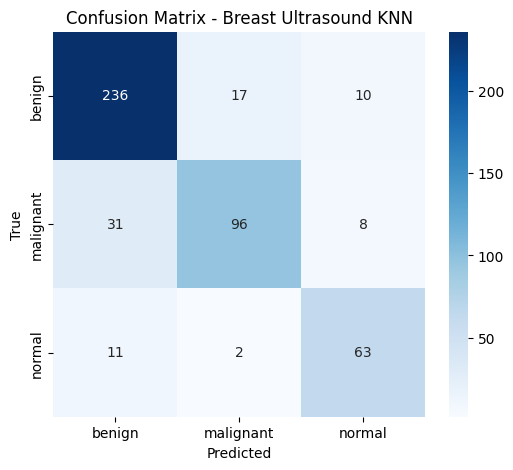


Classification Report:
               precision    recall  f1-score   support

      benign       0.85      0.90      0.87       263
   malignant       0.83      0.71      0.77       135
      normal       0.78      0.83      0.80        76

    accuracy                           0.83       474
   macro avg       0.82      0.81      0.81       474
weighted avg       0.83      0.83      0.83       474



In [ ]:
# --------------------------------------------------------
# 8️⃣  Evaluate KNN
# --------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = knn_model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Check shapes
print("y_test shape:", np.shape(y_test))
print("y_pred shape:", np.shape(y_pred))

# Flatten if needed
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Test Accuracy: {acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.title("Confusion Matrix - Breast Ultrasound KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=dataset.classes))


In [ ]:
# --------------------------------------------------------
# 🧩 9️⃣  Save trained model
# --------------------------------------------------------
import joblib
joblib.dump(knn_model, "/content/breast_ultrasound_knn.pkl")
print("💾 Model saved as breast_ultrasound_knn.pkl")


💾 Model saved as breast_ultrasound_knn.pkl


# Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on test set
y_pred = knn_model.predict(X_test)
val_acc = accuracy_score(y_test, y_pred) * 100

print(f"🎯 Test Accuracy: {val_acc:.2f}%")


🎯 Test Accuracy: 83.33%


# Evaluation (Accuracy, Confusion Matrix, Plots)

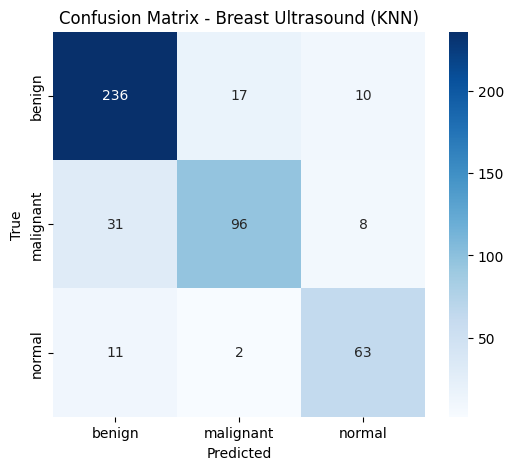

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.title("Confusion Matrix - Breast Ultrasound (KNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()




In [ ]:
# ✅ 3. Classification Report
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=dataset.classes))


Classification Report:
               precision    recall  f1-score   support

      benign       0.85      0.90      0.87       263
   malignant       0.83      0.71      0.77       135
      normal       0.78      0.83      0.80        76

    accuracy                           0.83       474
   macro avg       0.82      0.81      0.81       474
weighted avg       0.83      0.83      0.83       474



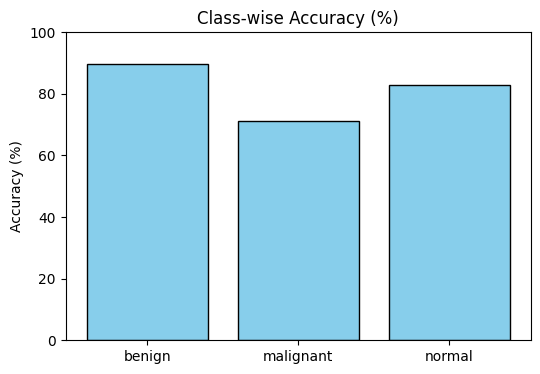

In [ ]:
# ✅ 4. Class-wise Accuracy Plot
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(6,4))
plt.bar(dataset.classes, class_accuracy * 100, color='skyblue', edgecolor='black')
plt.title("Class-wise Accuracy (%)")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.show()

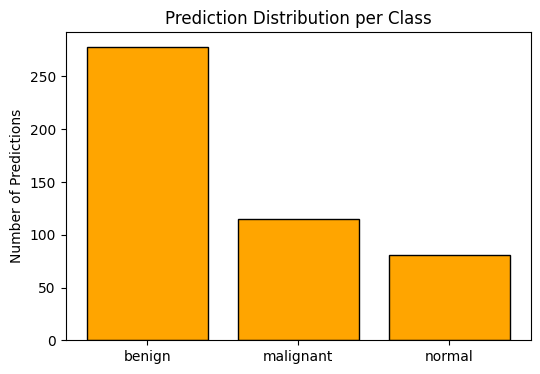

✅ Evaluation complete!


In [ ]:
# ✅ 5. Prediction Distribution
plt.figure(figsize=(6,4))
unique, counts = np.unique(y_pred, return_counts=True)
plt.bar(dataset.classes, counts, color='orange', edgecolor='black')
plt.title("Prediction Distribution per Class")
plt.ylabel("Number of Predictions")
plt.show()

print("✅ Evaluation complete!")

In [ ]:
import joblib
joblib.dump(knn_model, "breast_ultrasound_knn.pkl")
print("💾 Model saved successfully as breast_ultrasound_knn.pkl")


💾 Model saved successfully as breast_ultrasound_knn.pkl
